In [1]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sentencepiece as spm
import zipfile
import requests
from tqdm import tqdm
from transformers import ViTImageProcessor, GPT2Tokenizer
import torch.nn as nn
import torch.nn.init as init
from transformers import ViTModel, GPT2LMHeadModel

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

2024-04-17 08:50:48.451402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 08:50:48.451502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 08:50:48.585999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set the ZIP file download URL
zip_file_url = 'https://drive.usercontent.google.com/download?id=1FMVcFM78XZE1KE1rIkGBpCdcdI58S1LB&export=download&authuser=0&confirm=t&uuid=bf963761-6285-431e-8a17-f9ea4d1f01ce&at=APZUnTUZF79_K61JMipu1xrm0xIi%3A1712588788876'

# Set the directory to save the extracted files
extract_dir = '/content'

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Download the ZIP file
print('Downloading dataset ZIP file...')
response = requests.get(zip_file_url)
with open('/content/dataset.zip', 'wb') as f:
    f.write(response.content)

# Extract the ZIP file
print('Extracting dataset...')
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Extracting dataset...


In [3]:
#Loading the captions
train_captions = pd.read_csv('/content/custom_captions_dataset/train.csv')
train_captions.drop('Unnamed: 0', axis=1, inplace=True)

val_captions = pd.read_csv('/content/custom_captions_dataset/val.csv')
val_captions.drop('Unnamed: 0', axis=1, inplace=True)

test_captions = pd.read_csv('/content/custom_captions_dataset/test.csv')
test_captions.drop('Unnamed: 0', axis=1, inplace=True)

print(train_captions.head())

train_captions = train_captions['caption'].values
val_captions = val_captions['caption'].values
test_captions = test_captions['caption'].values

# Writing the captions to a text file
with open('/content/custom_captions_dataset/train_captions.txt', 'w') as f:
    for caption in train_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

with open('/content/custom_captions_dataset/val_captions.txt', 'w') as f:
    for caption in val_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

with open('/content/custom_captions_dataset/test_captions.txt', 'w') as f:
    for caption in test_captions:
        #Removing any \n from end
        caption = caption.replace('\n', '')
        f.write(caption + '\n')

      filename                                            caption
0  train_1.jpg  A white round plate is on a table with a plast...
1  train_2.jpg  There are four small pizzas on a brown wooden ...
2  train_3.jpg  A black and white cat is sitting in a white ch...
3  train_4.jpg  A boy is practicing his skateboard moves outsi...
4  train_5.jpg  Two brown horses are standing together outside...


In [4]:
# Set the directories containing the images and captions
train_image_dir = '/content/custom_captions_dataset/train'
train_caption_file = '/content/custom_captions_dataset/train_captions.txt'

val_image_dir = '/content/custom_captions_dataset/val'
val_caption_file = '/content/custom_captions_dataset/val_captions.txt'

test_image_dir = '/content/custom_captions_dataset/test'
test_caption_file = '/content/custom_captions_dataset/test_captions.txt'

# Defining the custom dataset class
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, caption_file):
        self.image_dir = image_dir
        self.image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        self.image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

        #Sorting the image paths
        self.image_paths.sort(key = lambda x: int(x.split('_')[-1].split('.')[0]))
        
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_bos_token = True)
        self.tokenizer.pad_token_id = self.tokenizer.bos_token_id

        # Loading the captions from the file
        with open(caption_file, 'r') as f:
            self.captions = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        pixel_values = self.image_processor(images=image, return_tensors="pt").pixel_values

        caption = self.captions[index]
        
        # Encode the caption
        input_ids = self.tokenizer.encode("Image Caption: " + caption + "<|endoftext|>")
        attention_mask = [1] * len(input_ids)
        labels = [-100 if token == self.tokenizer.bos_token_id else token for token in input_ids[:-1]]
        labels.append(input_ids[-1])
        
        return {
            "pixel_values": pixel_values,
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }
    
def collate_fn(batch):
    pixel_values = torch.cat([item["pixel_values"] for item in batch], dim=0)
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Find the maximum length of the input_ids across the batch
    max_length = max(len(ids) for ids in input_ids)

    # Pad the input_ids and attention_mask to the maximum length
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        [reversed(ids) for ids in input_ids], batch_first=True, padding_value=50256
    ).flip(1)
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(
        [reversed(mask) for mask in attention_mask], batch_first=True, padding_value=0
    ).flip(1)
    labels_padded = torch.nn.utils.rnn.pad_sequence(
        [reversed(lab) for lab in labels], batch_first=True, padding_value=-100
    ).flip(1)

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded
    }

# Create the dataset and dataloader
train_dataset = ImageCaptioningDataset(train_image_dir, train_caption_file)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

val_dataset = ImageCaptioningDataset(val_image_dir, val_caption_file)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

test_dataset = ImageCaptioningDataset(test_image_dir, test_caption_file)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [5]:
class ViTEncoder(nn.Module):
    def __init__(self):
        super(ViTEncoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        
        # Freeze all the layers
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, images):
        hidden_states = self.vit(images).last_hidden_state
        return hidden_states

class GPT2Decoder(nn.Module):
    def __init__(self):
        super(GPT2Decoder, self).__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', add_cross_attention = True)
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_bos_token = True)
        self.tokenizer.pad_token_id = self.tokenizer.bos_token_id

        for param in self.gpt2.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask, encoder_hidden_states, labels):
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            labels = labels,
            return_dict=True
        )
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = ViTEncoder()
        self.decoder = GPT2Decoder()

    def forward(self, images, input_ids, attention_mask, labels): 
        hidden_states = self.encoder(images)
        outputs = self.decoder(input_ids, attention_mask, hidden_states, labels)
        return outputs

    def generate_caption(self, image, max_length=200):
        image = image.cuda()
        self.eval()
        with torch.inference_mode():
            encoder_hidden_states = self.encoder(image)
            input_ids = self.decoder.tokenizer.encode("Image Caption:")
            input_ids = torch.tensor(input_ids).cuda()

            attention_mask = torch.ones_like(input_ids, device=image.device)

            generated_ids = []
            for _ in range(max_length):
#                 print(input_ids)
                outputs = self.decoder(input_ids, attention_mask, encoder_hidden_states, None)
                logits = outputs.logits[-1, :]
                predicted_id = torch.argmax(logits, axis=-1).item()
                generated_ids.append(predicted_id)

                if predicted_id == self.decoder.tokenizer.eos_token_id:
                    break

                input_ids = torch.cat([input_ids, torch.tensor([predicted_id], device=image.device)], dim=0)
                attention_mask = torch.ones_like(input_ids, device=image.device)

#             caption = self.decoder.tokenizer.decode(generated_ids, skip_special_tokens=True)
        caption = self.decoder.tokenizer.decode(generated_ids, skip_special_tokens=True)
        return caption


In [6]:
model = ImageCaptioningModel()

# Defining the loss function and optimizer
# criterion = nn.CrossEntropyLoss(ignore_index=sp.pad_id())
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 30

for epoch in range(num_epochs):
    # Storing total loss
    total_train_loss = 0
    total_val_loss = 0

    # Training loop
    model.train()
    train_pbar = tqdm(train_dataloader, leave=False)
    for i, batch in enumerate(train_pbar):
        pixel_values = batch['pixel_values'].cuda()
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()
        
        # Forward pass
        output = model(pixel_values, input_ids, attention_mask, labels)
        loss = output.loss
        total_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        train_pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss / (i + 1):.4f}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader):.4f}')
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_pbar = tqdm(val_dataloader, leave=False)
        for i, batch in enumerate(val_pbar):
            pixel_values = batch['pixel_values'].cuda()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # Forward pass
            output = model(pixel_values, input_ids, attention_mask, labels)
            loss = output.loss
            total_val_loss += loss.item()

            # Update the progress bar
            val_pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {total_val_loss / (i + 1):.4f}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {total_val_loss / len(val_dataloader):.4f}')

    # Save checkpoint
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'/kaggle/working/checkpoint_epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_dataloader),
            'val_loss': total_val_loss / len(val_dataloader)
        }, checkpoint_path)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Epoch [1/30], Train Loss: 2.4743


Epoch [1/30], Val Loss: 2.2807


Epoch [2/30], Train Loss: 2.0767


Epoch [2/30], Val Loss: 2.2681


Epoch [3/30], Train Loss: 1.7936


Epoch [3/30], Val Loss: 2.3305


Epoch [4/30], Train Loss: 1.5133


Epoch [4/30], Val Loss: 2.4863


Epoch [5/30], Train Loss: 1.2224


Epoch [5/30], Val Loss: 2.6482


Epoch [6/30], Train Loss: 0.9520


Epoch [6/30], Val Loss: 2.9919


Epoch [7/30], Train Loss: 0.7242


Epoch [7/30], Val Loss: 3.2699


Epoch [8/30], Train Loss: 0.5540


Epoch [8/30], Val Loss: 3.4876


Epoch [9/30], Train Loss: 0.4302


Epoch [9/30], Val Loss: 3.7624


Epoch [10/30], Train Loss: 0.3485


Epoch [10/30], Val Loss: 3.9324


Epoch [11/30], Train Loss: 0.2908


Epoch [11/30], Val Loss: 4.0881


Epoch [12/30], Train Loss: 0.2531


Epoch [12/30], Val Loss: 4.2294


Epoch [13/30], Train Loss: 0.2350


Epoch [13/30], Val Loss: 4.2791


Epoch [14/30], Train Loss: 0.2020


Epoch [14/30], Val Loss: 4.4172


Epoch [15/30], Train Loss: 0.1831


Epoch [15/30], Val Loss: 4.5131


Epoch [16/30], Train Loss: 0.1723


Epoch [16/30], Val Loss: 4.5448


Epoch [17/30], Train Loss: 0.1625


Epoch [17/30], Val Loss: 4.6019


Epoch [18/30], Train Loss: 0.1605


Epoch [18/30], Val Loss: 4.6626


Epoch [19/30], Train Loss: 0.1460


Epoch [19/30], Val Loss: 4.6716


Epoch [20/30], Train Loss: 0.1338


Epoch [20/30], Val Loss: 4.7905


Epoch [21/30], Train Loss: 0.1315


Epoch [21/30], Val Loss: 4.7804


Epoch [22/30], Train Loss: 0.1306


Epoch [22/30], Val Loss: 4.8576


Epoch [23/30], Train Loss: 0.1244


Epoch [23/30], Val Loss: 4.8768


Epoch [24/30], Train Loss: 0.1165


Epoch [24/30], Val Loss: 5.0081


Epoch [25/30], Train Loss: 0.1086


Epoch [25/30], Val Loss: 4.9376


Epoch [26/30], Train Loss: 0.1082


Epoch [26/30], Val Loss: 5.0258


Epoch [27/30], Train Loss: 0.1041


Epoch [27/30], Val Loss: 5.0003


Epoch [28/30], Train Loss: 0.1050


Epoch [28/30], Val Loss: 5.0593


Epoch [29/30], Train Loss: 0.0973


Epoch [29/30], Val Loss: 5.1540


Epoch [30/30], Train Loss: 0.0957


Epoch [30/30], Val Loss: 5.1423


In [7]:
model = ImageCaptioningModel()
model = model.cuda()
checkpoint_path = '/kaggle/working/checkpoint_epoch_30.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.

<All keys matched successfully>

In [8]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 24.3 MB/s eta 0:00:00


In [9]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

def evaluate_model(model):
    references = []
    predictions = []
    
    model.eval()
    with torch.inference_mode():
        ref_pbar = tqdm(test_dataloader, leave=False)
        for i, batch in enumerate(ref_pbar):
            pixel_values = batch['pixel_values'].cuda()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # Generating the caption
            output = model.generate_caption(pixel_values, 200)

            # Update the progress bar
            ref_pbar.set_description(f"Generating Caption for batch {i + 1}")
            
            predictions.append(output.strip())
            references.append(model.decoder.tokenizer.decode(input_ids[0, :], skip_special_tokens = True)[15:])
            
    bleu_refs = []
    bleu_preds = []
    
    dict_refs = {}
    dict_preds = {}
            
    for i in range(len(predictions)):
        ref_sentences = references[i].split('.')[:-1]
        ref_sentences = [ref_sentence.split() for ref_sentence in ref_sentences]
        pred_sentences = predictions[i].split('.')[:-1]
        pred_sentences = [pred_sentence.split() for pred_sentence in pred_sentences]
        
        for pred_sentence in pred_sentences:
            bleu_refs.append(ref_sentences)
            bleu_preds.append(pred_sentence)
            
    count = 0
    for i in range(len(predictions)):
        ref_sentences = references[i].split('.')[:-1]
        pred_sentences = predictions[i].split('.')[:-1]
        
        for pred_sentence in pred_sentences:
            dict_preds[count] = [pred_sentence]
            dict_refs[count] = ref_sentences
            count += 1
            
    bleu_score = corpus_bleu(bleu_refs, bleu_preds, smoothing_function=SmoothingFunction().method1, weights = (1, 0, 0, 0))
    rouge = Rouge()
    rouge_scores = rouge.compute_score(dict_refs, dict_preds)
    cider = Cider()
    cider_score, _ = cider.compute_score(dict_refs, dict_preds)
    return bleu_score, rouge_scores, cider_score
            
bleu_score, rouge_scores, cider_score = evaluate_model(model)
print(f"Bleu Score is {bleu_score}")
print(f"Rouge Score is {rouge_scores[0]}")
print(f"Cider Score is {cider_score}")

Bleu Score is 0.5161080998549508
Rouge Score is 0.3686027450362259
Cider Score is 0.16803940516260094


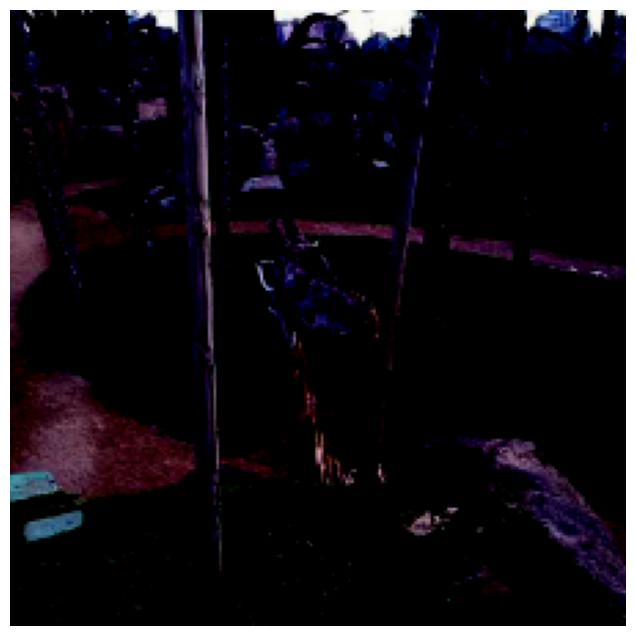

Generated Caption:  This is an image of a zebra. The zebra is walking in a zoo. The zebra has long neck. The giraffe is very furry. The zebra is walking on a dirt ground. There is a large hill behind the zebra. The hill is made of tan dirt with some small patches of grass. There is a small structure in the background. This looks like a zoo.


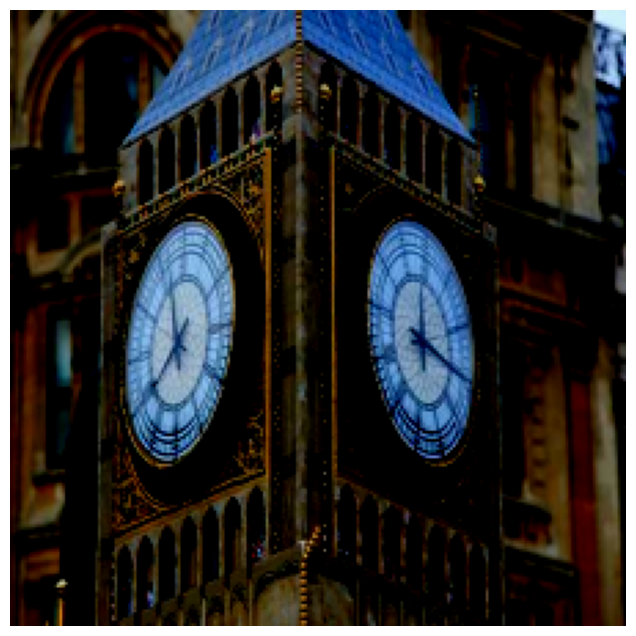

Generated Caption:  This is a photo of a large brick building with a clock on the side of it. The clock is black and the hands are white. The clock is at the top of a tan brick building. The building has many windows on it. There is a pointed light on the building that is green. The sky above the building is blue with large clouds. There is another building to the right of the clock.


In [10]:
#Sample Outputs
model.eval()
num_examples = 2
for i in range(num_examples):
    batch = test_dataset[i + 249]
    pixel_values = batch['pixel_values'].cuda()
    input_ids = batch['input_ids'].cuda()
    attention_mask = batch['attention_mask'].cuda()
    labels = batch['labels'].cuda()
    

    # Generate the caption
    outputs = model.generate_caption(pixel_values)

    # Display the image
    image = pixel_values.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print the generated caption
    print(f"Generated Caption: {outputs}")